In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random

In [2]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
oregon_wildlife\bald_eagle
oregon_wildlife\black_bear
oregon_wildlife\cougar
oregon_wildlife\deer
oregon_wildlife\nutria
oregon_wildlife\raccoon
oregon_wildlife\raven
oregon_wildlife\red_fox
oregon_wildlife\sea_lions
oregon_wildlife\virginia_opossum

total img num: 7168


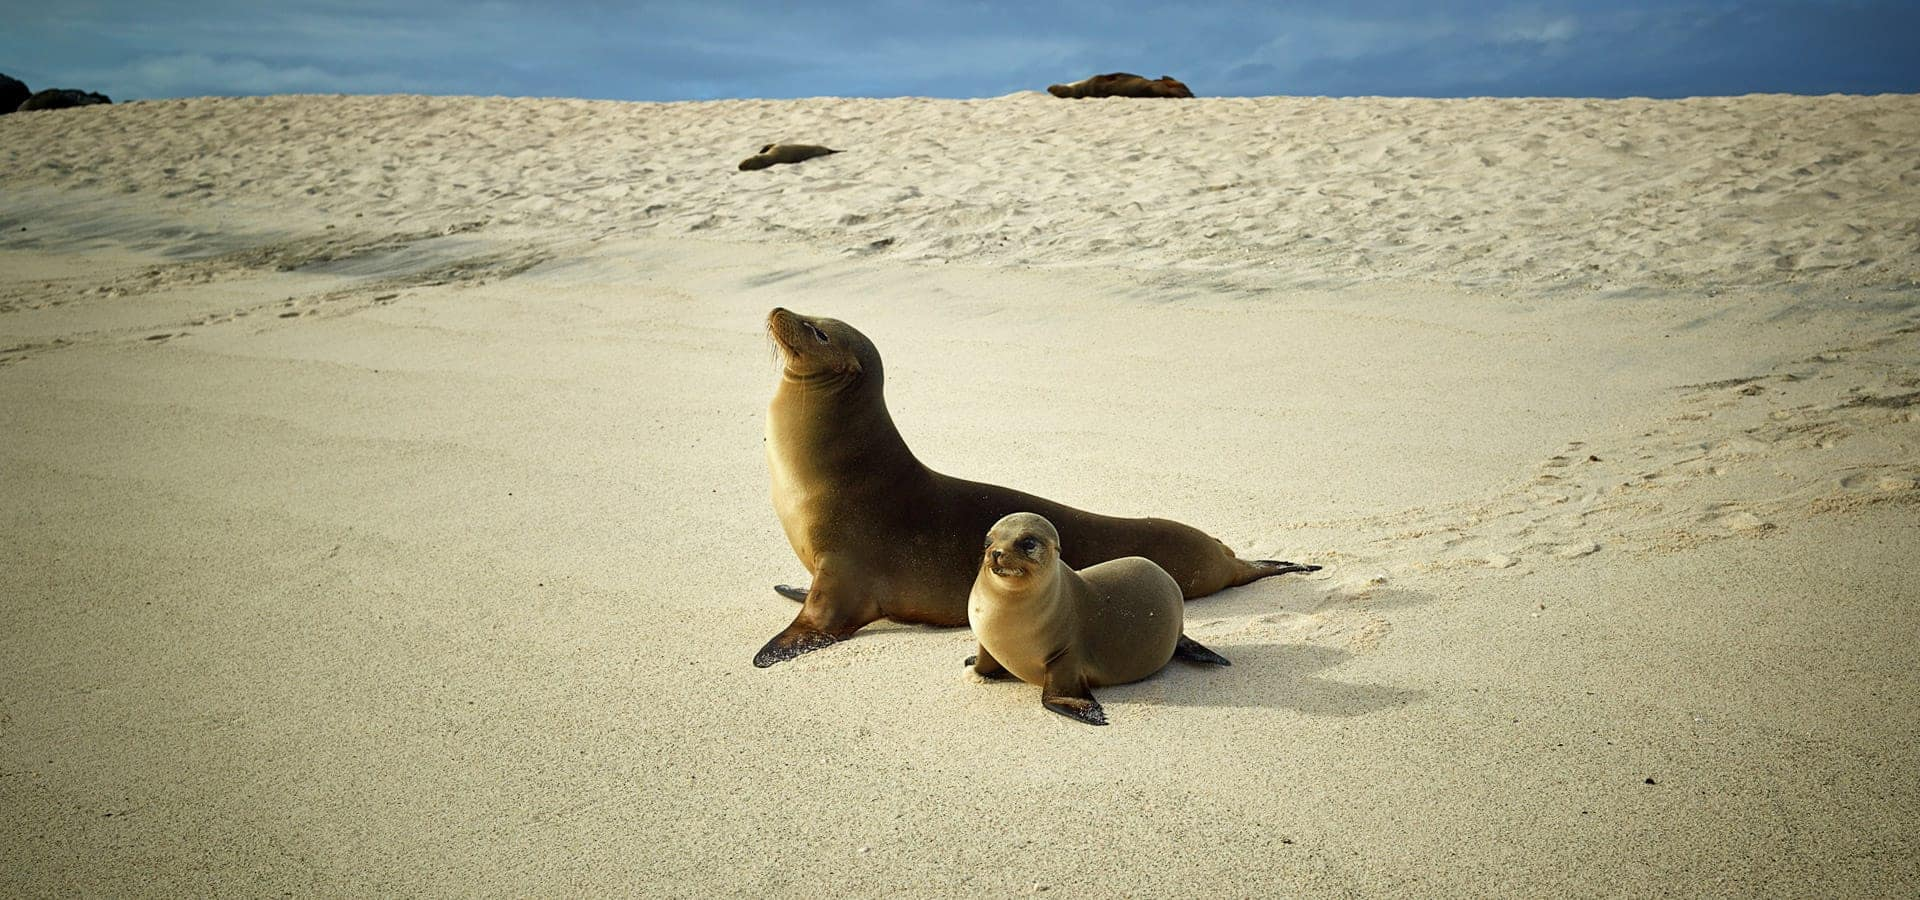

sea_lions


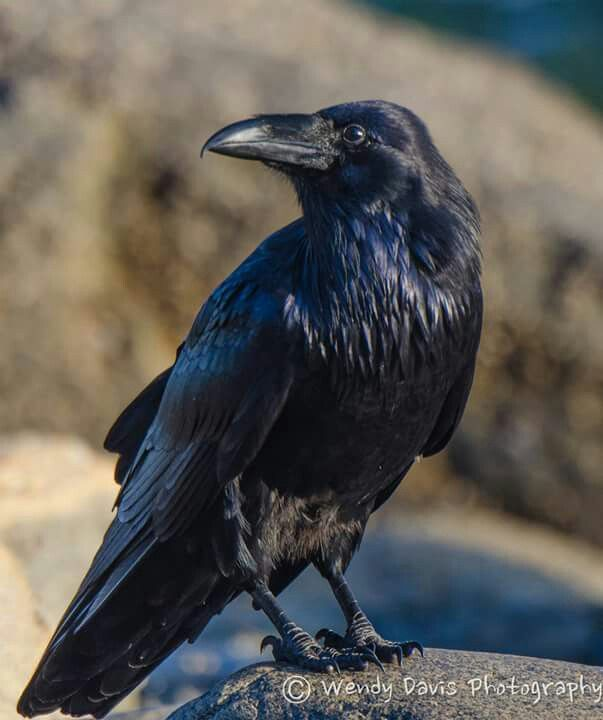

raven


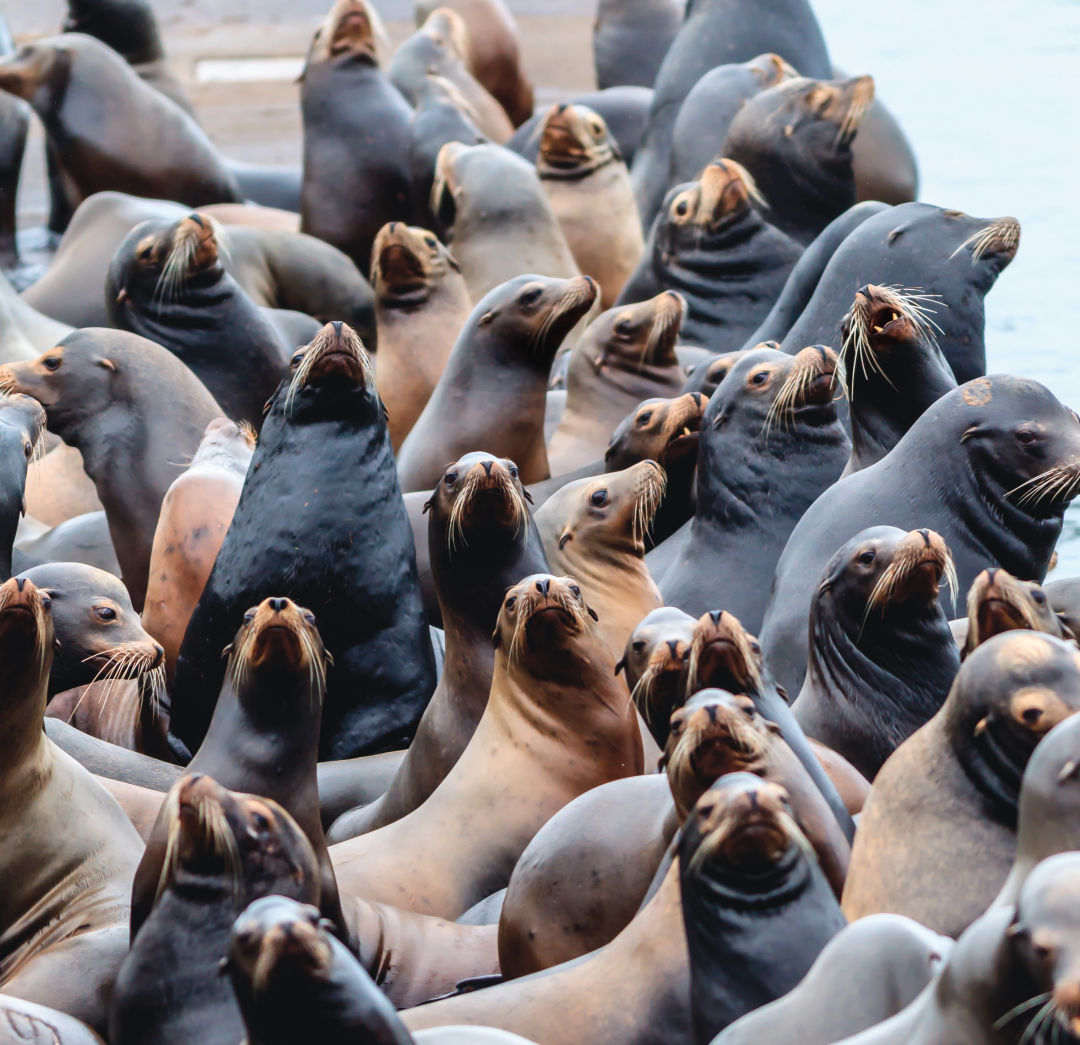

sea_lions


In [3]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('\\')[-2])

In [4]:
# get the labels
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total labels
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [5]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [6]:
# get the label data
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [8, 5, 2, 5, 0, 2, 1, 0, 1, 0]


In [7]:
# Create training and validation sets using an 80-20 split
img_path_train, img_path_val, label_train, label_val = train_test_split(all_image_paths,
                                all_image_labels,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_val)))

training data: 5734
testing data: 1434


In [8]:
# You will use these setting in your code, pls do not modify these 4.
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3


# feel free to modify these Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 32

In [9]:
# loda images
def load_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img, label

In [10]:
# the dataset objects we prepared for you
dataset_train = tf.data.Dataset.from_tensor_slices((img_path_train, label_train))
dataset_train = dataset_train.map(load_image)
#dataset_train = dataset_train.map(map_fun)

dataset_val = tf.data.Dataset.from_tensor_slices((img_path_val,label_val))
dataset_val = dataset_val.map(load_image)
#dataset_val = dataset_val.map(map_fun_test)

In [11]:
dataset_train

<MapDataset shapes: ((300, 300, 3), ()), types: (tf.float32, tf.int32)>

In [12]:
# # # show one image here.
# for img, label in dataset_train.take(2):
#     print(img.shape)
#     plt.imshow(img) 
#     plt.axis('off') 
#     plt.show()
#     print(index_to_label[label.numpy()])

# todo1: write the dataset above to tfrecord

In [13]:
# The following functions can be used to convert a value to a type compatible with tf.Example.
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [14]:
# _bytes_feature(img.numpy().tostring())

def serialize_example(img, label):
    """
    Creates a tf.Example message ready to be written to a file.
    """
    # Create a dictionary mapping the feature name to the tf.Example-compatible data type.
    feature = {
        'img': _float_feature(img.numpy().reshape(-1)),
        'label': _int64_feature(label),
    }

    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    
    return example_proto.SerializeToString()

def tf_serialize_example(img, label):
    tf_string = tf.py_function(
        serialize_example,
        (img, label),  # pass these args to the above function.
        tf.string)      # the return type is `tf.string`.
    return tf.reshape(tf_string, ()) # The result is a scalar

In [15]:
serialized_features_dataset = dataset_train.map(tf_serialize_example)
serialized_features_dataset

filename = './data/dataset_train.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset)

In [16]:
serialized_features_dataset = dataset_val.map(tf_serialize_example)
serialized_features_dataset

filename = './data/dataset_val.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset)

# todo2: read the data from tfrecord you get in Todo1

In [17]:
raw_image_dataset = tf.data.TFRecordDataset('./data/dataset_train.tfrecord')

image_feature_description = {
    'img': tf.io.FixedLenFeature(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH), dtype=tf.float32),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_function(example_proto):
  # Parse the input `tf.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

dataset_train = raw_image_dataset.map(_parse_function)
dataset_train

<MapDataset shapes: {img: (300, 300, 3), label: ()}, types: {img: tf.float32, label: tf.int64}>

In [18]:
raw_image_dataset = tf.data.TFRecordDataset('./data/dataset_val.tfrecord')

image_feature_description = {
    'img': tf.io.FixedLenFeature(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH), dtype=tf.float32),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_function(example_proto):
  # Parse the input `tf.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

dataset_val = raw_image_dataset.map(_parse_function)
dataset_val

<MapDataset shapes: {img: (300, 300, 3), label: ()}, types: {img: tf.float32, label: tf.int64}>

In [19]:
print(dataset_train)
print(dataset_val)

<MapDataset shapes: {img: (300, 300, 3), label: ()}, types: {img: tf.float32, label: tf.int64}>
<MapDataset shapes: {img: (300, 300, 3), label: ()}, types: {img: tf.float32, label: tf.int64}>


# todo3: remember to preprocess the data. You can refer to the code in the Cifar10 section.

In [20]:
# parse training data
def map_fun(data):
    image = data['img']
    label = data['label']
    #image = tf.reshape(image,[IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    #image = tf.divide(tf.cast(tf.transpose(image,[1,2,0]),tf.float32),255.0)
    #label = tf.one_hot(label,10)
    distorted_image = tf.image.random_crop(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,3])
#     distorted_image = tf.image.random_flip_left_right(distorted_image)
#     distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
#     distorted_image = tf.image.random_contrast(
#         distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    return distorted_image, label

# parse testing data
def map_fun_test(data):
    image = data['img']
    label = data['label']
    #image = tf.reshape(image,[IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    #image = tf.divide(tf.cast(tf.transpose(image,[1,2,0]),tf.float32),255.0)
    #label = tf.one_hot(label,10)
    distorted_image = tf.image.resize_with_crop_or_pad(image, IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    return distorted_image, label

In [21]:
dataset_train

<MapDataset shapes: {img: (300, 300, 3), label: ()}, types: {img: tf.float32, label: tf.int64}>

In [22]:
dataset_train = dataset_train.map(map_fun)
dataset_train

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>

In [23]:
dataset_val = dataset_val.map(map_fun_test)
dataset_val

<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>

In [24]:
# # show one image here.
# for img, label in dataset_train.take(1):
#     print(img.shape)
#     plt.imshow(img) 
#     plt.axis('off') 
#     plt.show()
#     print(index_to_label[label.numpy()])

In [25]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32

dataset = dataset_train.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((32, 224, 224, 3), (32,)), types: (tf.float32, tf.int64)>

In [26]:
dataset_v = dataset_val.batch(BATCH_SIZE, drop_remainder=True)
dataset_v

<BatchDataset shapes: ((32, 224, 224, 3), (32,)), types: (tf.float32, tf.int64)>

In [27]:
dataset = dataset.prefetch(buffer_size=BUFFER_SIZE)
dataset_v = dataset_v.prefetch(buffer_size=BUFFER_SIZE)

In [28]:
dataset

<PrefetchDataset shapes: ((32, 224, 224, 3), (32,)), types: (tf.float32, tf.int64)>

In [29]:
dataset_v

<PrefetchDataset shapes: ((32, 224, 224, 3), (32,)), types: (tf.float32, tf.int64)>

In [30]:
# def dict2list(img, label):
#     return ([img], [label])

# dataset_train = dataset_train.map(dict2list)
# dataset_val = dataset_val.map(dict2list)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


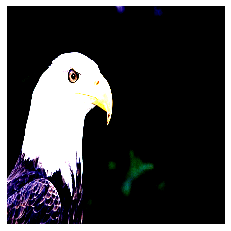

bald_eagle


In [31]:
# # show one image here.
for data in dataset.take(1):
    img = data[0][0]
    label = data[1][0]
    print(img.shape)
    plt.imshow(img, interpolation='none') 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label.numpy()])

# Train Model

In [32]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

In [33]:
wild_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

wild_model.fit(dataset, validation_data=dataset_v, epochs=5)

Epoch 1/5
179/179 [==============================] - 57s 317ms/step - loss: 2.7213 - accuracy: 0.5731 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
179/179 [==============================] - 51s 284ms/step - loss: 0.6510 - accuracy: 0.7909 - val_loss: 0.2713 - val_accuracy: 0.9134
Epoch 3/5
179/179 [==============================] - 51s 284ms/step - loss: 0.5323 - accuracy: 0.8413 - val_loss: 0.2074 - val_accuracy: 0.9318
Epoch 4/5
179/179 [==============================] - 51s 284ms/step - loss: 0.4656 - accuracy: 0.8616 - val_loss: 0.2169 - val_accuracy: 0.9290
Epoch 5/5
179/179 [==============================] - 51s 284ms/step - loss: 0.4195 - accuracy: 0.8762 - val_loss: 0.2203 - val_accuracy: 0.9311
